# EXTRA: Feature Importances 

In [6]:
# !pip install shap

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool



from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

from utils import *

import shap

In [8]:
df = pd.read_csv("data/train_new_feats.csv")


In [9]:
target = [[f"target_{i}" for i in range(1, 9)] + ["Claim Injury Type"] + ["WCB Decision"] + ["Agreement Reached"] + ["Claim Injury Type_encoded"]]
target = [item for sublist in target for item in sublist]
target

binary_target = [f"target_{i}" for i in range(1, 9)]

original_target  = [col for col in target if col not in binary_target]

ordinal_target = ["Claim Injury Type_encoded"]

features = [feat for feat in df.columns if feat not in target]

features = [feat for feat in features if df[feat].dtype != "datetime64[ns]"]

num_feats = [feat for feat in features if df[feat].dtype != "object"]

cat_feats = [feat for feat in features if df[feat].dtype == "object"]
cat_feats_index = [features.index(feat) for feat in cat_feats]

In [10]:

selected_features = [
    'Age at Injury',
    'Attorney/Representative',
    'IME-4 Count',
    'Accident Date_year',
    'Accident Date_assembly_gap_days',
    'C3-C2_gap_days',
    'C2_missing',
    'C3_missing',
    'C3_Accident_gap_weeks',
    'Hearing_C3 gap_months',
    'Hearing_C2 gap_months',
    'Days to Assembly',
    'Days to First Hearing',
    'Average Weekly Wage_log',
    'Carrier Name_encoded',
    'County of Injury_encoded',
    'Industry Code Description_encoded',
    'WCIO Cause of Injury Description_encoded',
    'WCIO Nature of Injury Description_encoded',
    'WCIO Part Of Body Description_encoded',
    'Zip Code_encoded',
    'County of Worker_encoded',
    'Carrier Name_freq',
    'County of Injury_freq',
    'District Name_freq',
    'Industry Code Description_freq',
    'WCIO Cause of Injury Description_freq',
    'WCIO Nature of Injury Description_freq',
    'WCIO Part Of Body Description_freq',
    'Zip Code_freq',
    'County of Worker_freq'
 ]


naive_features = [feat.replace("_encoded", "") for feat in selected_features]
naive_features = [feat.replace(f"_freq", "") for feat in naive_features]
naive_features = set(naive_features)
naive_features = list(naive_features)

cat_feats = [feat for feat in naive_features if feat in cat_feats]


In [11]:
X = df[naive_features]
y = df[ordinal_target]

X_encoded = X.copy()
X_encoded_ = X.copy()

In [12]:

print(f"Ordinal encoding...")
X_train_encoded = X_encoded.copy()
X_val_encoded = X_encoded_.copy()
for cat in cat_feats:
    X_train_encoded, X_val_encoded, ordinal_mapping = target_guided_ordinal_encoding(X_train_encoded, X_val_encoded, cat, ordinal_target, y, 0)

print(f"Frequency encoding...")
for cat in cat_feats:
    X_train_encoded, X_val_encoded, freq_map = frequency_encoding(X_train_encoded, X_val_encoded, cat)

print(f"Selecting features...")
X_train_encoded  = X_train_encoded[selected_features]
X_val_encoded = X_val_encoded[selected_features]

print(f"Numerical imputing...")
X_train_imputed, X_val_imputed = num_imputing(X_train_encoded, X_val_encoded)

Ordinal encoding...
Frequency encoding...
Selecting features...
Numerical imputing...


In [14]:
clf = CatBoostClassifier(
    random_state=42, 
    verbose=200, 
    iterations=1000, 
    depth=6, 
    boosting_type='Ordered', 
    auto_class_weights='SqrtBalanced', 
    loss_function="MultiClassOneVsAll"
    )

clf.fit(X_train_imputed, y)

0:	learn: 0.6714078	total: 485ms	remaining: 8m 4s
200:	learn: 0.1829458	total: 1m 26s	remaining: 5m 44s
400:	learn: 0.1726725	total: 2m 51s	remaining: 4m 16s
600:	learn: 0.1682870	total: 4m 15s	remaining: 2m 49s
800:	learn: 0.1655144	total: 5m 39s	remaining: 1m 24s
999:	learn: 0.1635393	total: 7m 3s	remaining: 0us


Feature importances


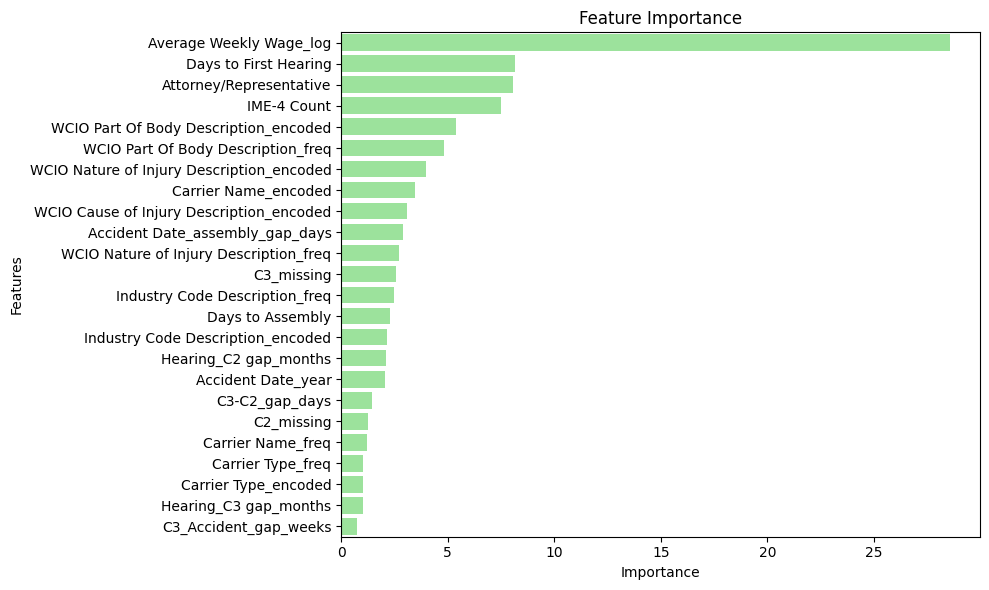

In [ ]:
print("Feature importances")

feature_importance = clf.get_feature_importance()
feature_names = clf.feature_names_
len(feature_importance), len(feature_names)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], color="lightgreen")
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [ ]:
# SHAP Values for deeper insights
explainer = shap.TreeExplainer(clf)

In [ ]:
shap_values = explainer.shap_values(X_train_imputed)

In [ ]:
Mean_0 = np.mean(np.abs(shap_values[:,:,0]), axis=0)
Mean_1 = np.mean(np.abs(shap_values[:,:,1]), axis=0)
Mean_2 = np.mean(np.abs(shap_values[:,:,2]), axis=0)
Mean_3 = np.mean(np.abs(shap_values[:,:,3]), axis=0)
Mean_4 = np.mean(np.abs(shap_values[:,:,4]), axis=0)
Mean_5 = np.mean(np.abs(shap_values[:,:,5]), axis=0)
Mean_6 = np.mean(np.abs(shap_values[:,:,6]), axis=0)
Mean_7 = np.mean(np.abs(shap_values[:,:,7]), axis=0)

In [ ]:
ex = pd.DataFrame({"Feature": X_train_imputed.columns, "1.Canceld": Mean_0, "2.Noncomp": Mean_1, "3.MedOnly": Mean_2, "4.Temp": Mean_3, "5.PPD": Mean_4, "6.PPDNSL": Mean_5, "7.PTD": Mean_6, "8.Death": Mean_7})
ex.set_index("Feature", inplace=True)


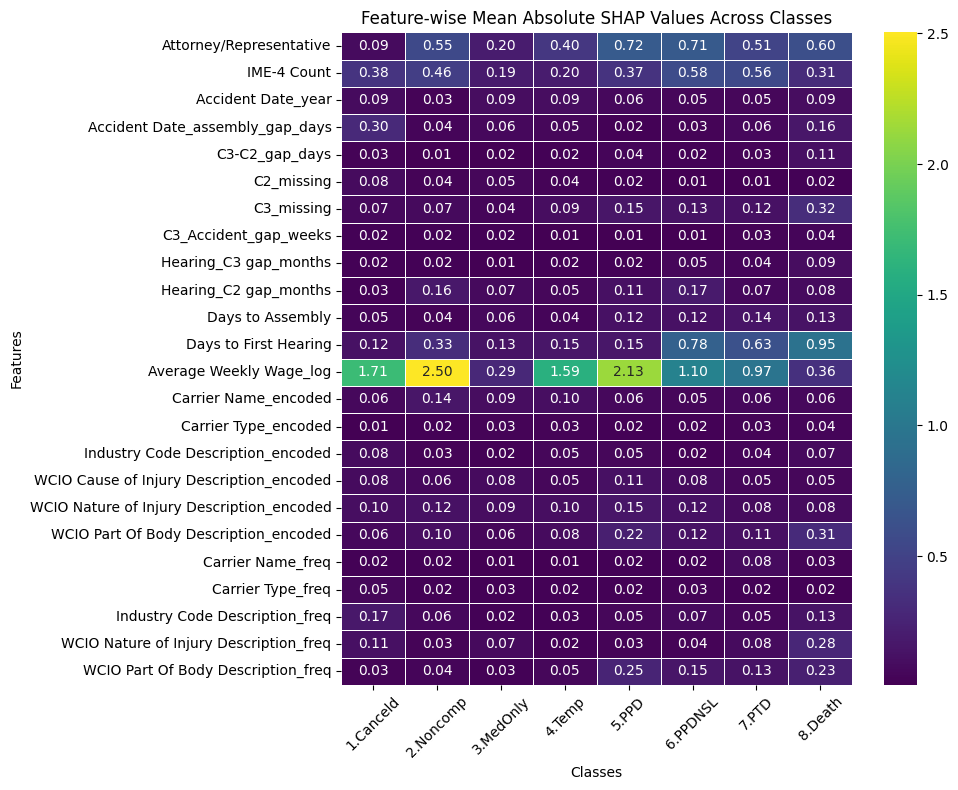

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(ex, cmap="viridis", annot=True, fmt=".2f", linewidths=0.5, cbar=True)

# Labeling
plt.title("Feature-wise Mean Absolute SHAP Values Across Classes")
plt.xlabel("Classes")
plt.xticks(rotation=45)
plt.ylabel("Features")

# Show plot
plt.tight_layout()
plt.show()